In [1]:
%load_ext autoreload 
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import surp
import surp.gce_math as gcem
import arya
import vice

/astro/dboyea/.local/lib/python3.11/site-packages/vice/__init__.py:141: UserWarning: Using un-released version of VICE
  warnings.warn("Using un-released version of VICE", UserWarning)


In [3]:
import seaborn as sns
import matplotlib as mpl
import matplotlib.patheffects

In [4]:
calc_y = np.vectorize(surp.yields.calc_y)

In [5]:
from singlezone import run_singlezone

In [6]:
surp.set_yields()

yields set to Magg et al. 2022 abundances
Yield settings
X        Z_solar    CC                             agb                            SN Ia                          

c        3.39e-03   3.69e-03 MH^2 + 1.96e-03 MH +  1.45 × cristallo11             0.00e+00                       
                    2.20e-03                                                                                     

n        1.04e-03   5.00e-04                       5.02e-04 M Z/Z0                0                              

o        7.33e-03   7.13e-03                       0                              0                              

mg       6.71e-04   6.52e-04                       0                              0                              

fe       1.37e-03   4.73e-04                       0                              7.70e-04                       





## Loading and plotting a model

In [7]:
def load_model(name):
    """
    Finds the pickled model with either the given name or the parameters 
    and returns the csv summary
    """
    yield_params = surp.YieldParams.from_file("../models/" + name + "/yield_params.toml")
    surp.set_yields(yield_params, verbose=False)
    
    file_name = "../models/" + name + "/stars.csv"
    model =  pd.read_csv(file_name, index_col=0)

    return model

In [55]:
def load_gas_model(name):
    """
    Finds the pickled model with either the given name or the parameters 
    and returns the csv summary
    """
    
    file_name = "../models/" + name + "/model.json"
    model =   surp.ViceModel.from_file(file_name)

    return model.history

In [57]:
gh = load_gas_model("fiducial/run")

In [9]:
model = load_model("fiducial/run")

In [10]:
def scatter_caah(model):
    kwargs = dict(
        rasterized=True, ec="none", s=1, 
    )


    sns.scatterplot(model, x="MG_H", y="C_MG", hue="high_alpha", **kwargs)

    L = arya.Legend(labels=[r"low $\alpha$", r"high $\alpha$"], color_only=True, loc=4)
    for text in L.mpl_leg.get_texts():
        text.set_path_effects([mpl.patheffects.Stroke(linewidth=3, foreground='w'),
                           mpl.patheffects.Normal()])



    plt.xlim(-0.5, 0.5)
    plt.ylim(-0.45, 0.15)
    plt.ylabel("[C/Mg]")
    plt.xlabel("[Mg/H]")

In [11]:

def scatter_caafe(model):
    kwargs = dict(
        rasterized=True, ec="none", s=1
    )
    
    sns.scatterplot(model, x="MG_FE", y="C_MG", hue="MG_H", hue_norm=(-0.5, 0.5), legend=False,  palette=plt.get_cmap(), **kwargs)
    plt.xlim(-0.08, 0.45)
    
    cax = plt.gca().inset_axes([1.05, 0., 0.05, 1])

    arya.Colorbar(clim=(-0.5, 0.5), label="[Mg/H]", cax=cax)

    plt.xlabel("[Mg/Fe]")

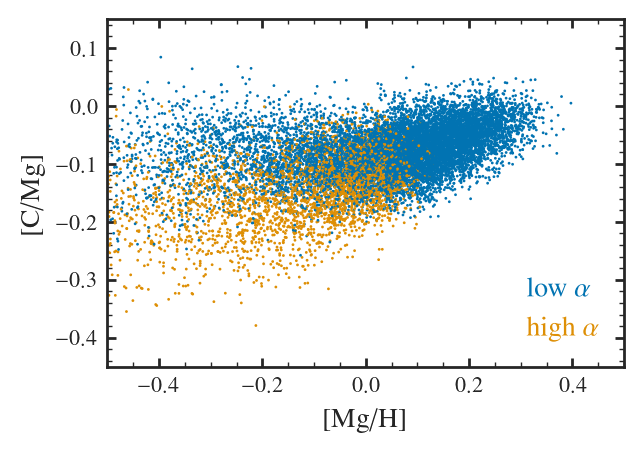

In [12]:
scatter_caah(model)

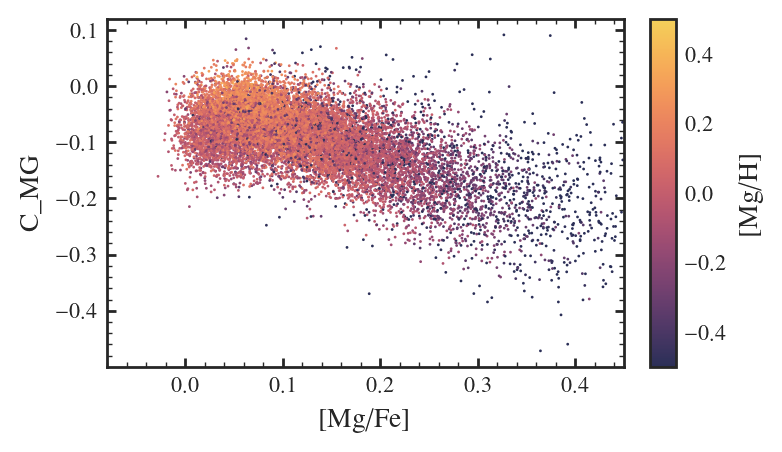

In [13]:
scatter_caafe(model)

In [33]:
def binned_caah(model):
    arya.medianplot(model[~model.high_alpha], "MG_H", "C_MG", 
                    numbins=20, color="k", stat="median")

def binned_caafe(model):
    arya.medianplot(model, "MG_FE", "C_MG", numbins=20, color="k",
                   stat="median")
    
def binned_caafe_slice(model, w=0, c0=-0.1):
    df = surp.plots.filter_metallicity(model, c=-0.1, w=5)
    arya.medianplot(model, "MG_FE_true", "C_MG_true", numbins=12, color="k", 
        stat="median")


In [63]:
def plot_gas_today(h, x="MG_H", y="C_MG"):
    filt = h.time == np.max(h.time)
    filt &= h.R < 15
    df = h[filt]
    plt.scatter(df[x], df[y])

In [66]:
def plot_gas_caafe(h, R0=8.0, x="MG_FE", y="C_MG"):
    Rs = h.R.unique()
    R0 = Rs[np.argmin(np.abs(R0 - Rs))]
    print("using ", R0)

    filt = h.R == R0
    df = h[filt]
    plt.scatter(df[x], df[y])


In [86]:
def compare_coofe_gas(gh, sfh=None): 
    plot_gas_caafe(gh)
    sz_caafe(sfh=sfh, color="k")
    plot_ssp_femg(0.016)
    

In [70]:
def compare_cooh_gas(model):
    plot_gas_today(model)
    plot_eq_caah()
    plt.xlabel("[Mg/H]")
    plt.ylabel("[C/Mg]")

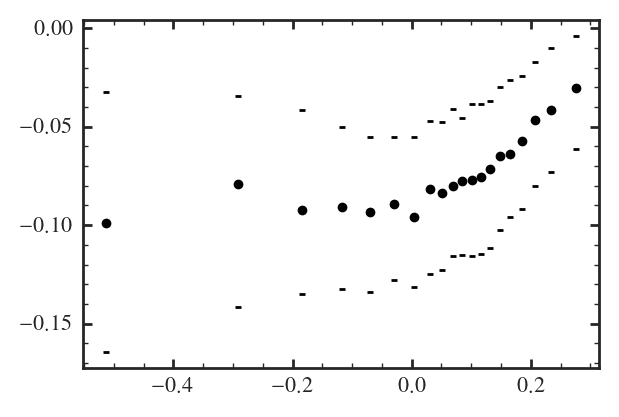

In [15]:
binned_caah(model)

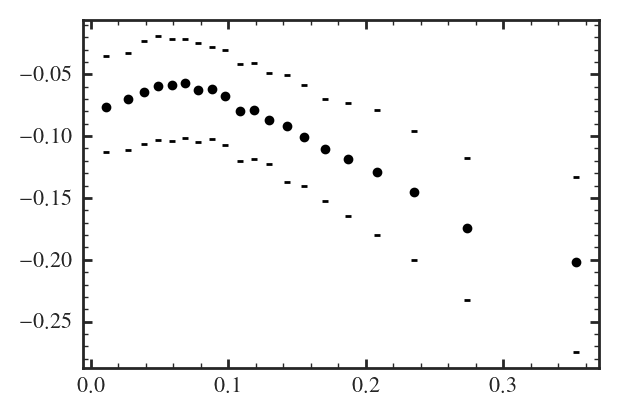

In [16]:
binned_caafe(model)

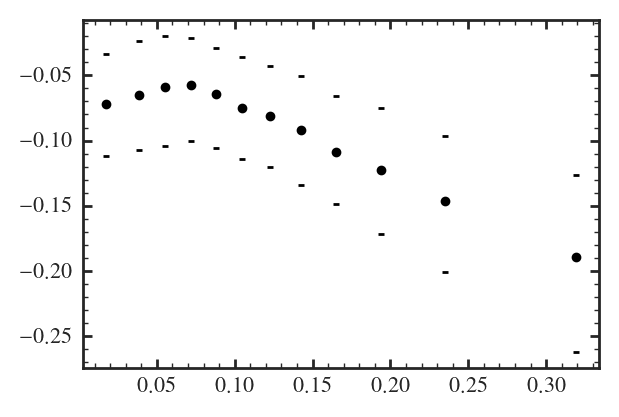

In [17]:
binned_caafe_slice(model)

## equilibrium

In [45]:
eq_correction = 10**-0.00

def calc_eq_caah(M_H, **kwargs):
    Zs = gcem.MH_to_Z(M_H)
    ys = calc_y(Zs)
    ymg = calc_y(Zs, "mg")

    co = gcem.abund_ratio_to_brak(ys / ymg*eq_correction, "C", "MG")
    
    return co

def plot_eq_caah(M_H =np.linspace(-0.45, 0.45, 1000),  **kwargs):
    co = calc_eq_caah(M_H)
    
    plt.plot(M_H, co, label="equilibrium", color="k", lw=2, **kwargs)
    
    
def plot_eq_caafe(**kwargs):
    M_H = np.linspace(-0.45, 0.45, 1000)
    Zs = gcem.MH_to_Z(M_H)
    yc = calc_y(Zs)
    ymg = calc_y(Zs, "mg")
    yfe = calc_y(Zs, "fe")

    co = gcem.abund_ratio_to_brak(yc / ymg * 10**-0.05, "C", "MG")
    ofe = gcem.abund_ratio_to_brak(ymg/yfe, "mg", "fe")
    
    plt.plot(ofe, co, label="equilibrium", **kwargs)
    
def sz_caafe(eta=0.5, sfh=None, tau_star=3.2, **kwargs):
    if sfh is None:
        sfh = surp.simulation.sfh_models.insideout(tau_sfh=15)
    sz, h = run_singlezone(eta=eta, sfh=sfh, tau_star=tau_star)
    plt.plot(h.O_FE, h.C_O, **kwargs)
    return sz

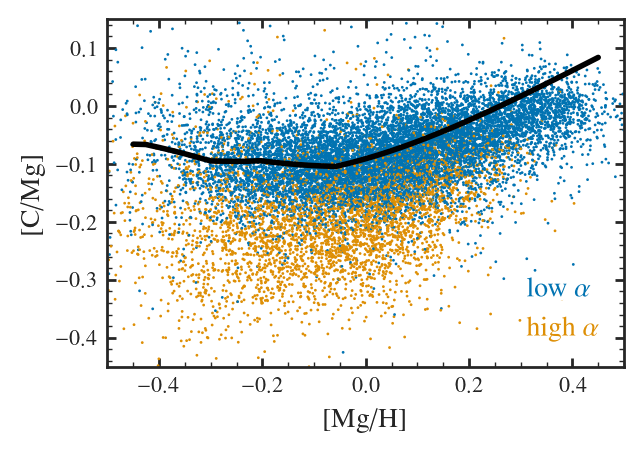

In [19]:
scatter_caah(surp.subgiants)
plot_eq_caah()


In [20]:
def compare_caah(model):
    #plot_data()
    scatter_caah(model)
    binned_caah(model)
    plot_eq_caah()
    
    plt.xlim(-0.5, 0.5)
    plt.ylim(-0.6, 0.1)
    plt.xlabel("[Mg/H]")
    plt.ylabel("[C/Mg]")

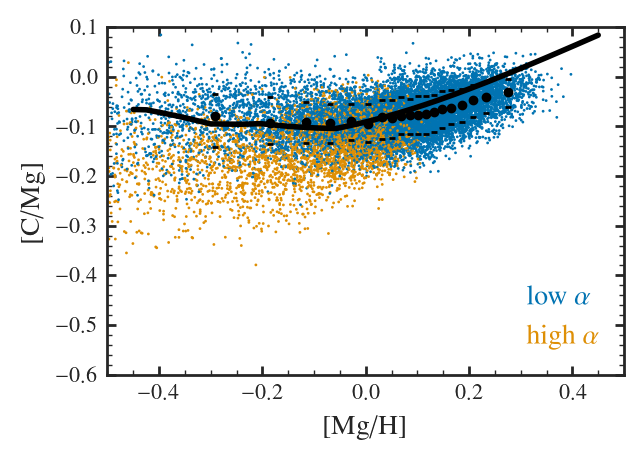

In [21]:
compare_caah(model)

In [31]:
def compare_caafe(model, **kwargs):
    scatter_caafe(model)
    binned_caafe_slice(model)
    plot_eq_caafe(lw=2, color="k")
    sz_caafe(label="singlezone", sfh=sfh, lw=2, color=arya.COLORS[2])

    plt.xlabel("[Mg/Fe]")
    plt.ylabel("[C/Mg]")

In [24]:
def plot_ssp_mgh(Z, **kwargs):
    m_c, times = vice.single_stellar_population("c", Z=Z, mstar=1)
    m_mg, times = vice.single_stellar_population("mg", Z=Z, mstar=1)

    c_mg = gcem.abund_ratio_to_brak(np.array(m_c)/m_mg, "C", "MG")
    fe_mg = gcem.abund_ratio_to_brak(np.array(m_mg), "Fe", "MG")
    plt.plot(mg_h, c_mg, **kwargs)


In [25]:
def plot_ssp_femg(Z, x_shift = 0, color=arya.COLORS[2],  **kwargs):
    m_c, times = vice.single_stellar_population("c", Z=Z, mstar=1)
    m_mg, times = vice.single_stellar_population("mg", Z=Z, mstar=1)
    m_fe, times = vice.single_stellar_population("fe", Z=Z, mstar=1)

    c_mg = gcem.abund_ratio_to_brak(np.array(m_c)/m_mg, "C", "MG")
    mg_fe = gcem.abund_ratio_to_brak(np.array(m_mg)/m_fe, "MG", "FE")
    plt.plot(mg_fe + x_shift, c_mg, color=color, **kwargs)


/astro/dboyea/.local/lib/python3.11/site-packages/vice/core/singlezone/singlezone.py:1797: VisibleRuntimeWarning: Functions of stellar mass and metallicity for asymptotic giant branch star yields may significantly increase the required integration time, especially for fine timestepping.
  return self.__c_version.run(output_times, capture = capture,
/astro/dboyea/.local/lib/python3.11/site-packages/vice/core/pickles.py:310: UserWarning: Encoding functions along with VICE outputs requires the package dill (installable via pip). The following attribute will not be saved with this output: c
  warnings.warn("""\
/astro/dboyea/.local/lib/python3.11/site-packages/vice/core/pickles.py:310: UserWarning: Encoding functions along with VICE outputs requires the package dill (installable via pip). The following attribute will not be saved with this output: n
  warnings.warn("""\
/astro/dboyea/.local/lib/python3.11/site-packages/vice/core/pickles.py:310: UserWarning: Encoding functions along with VI

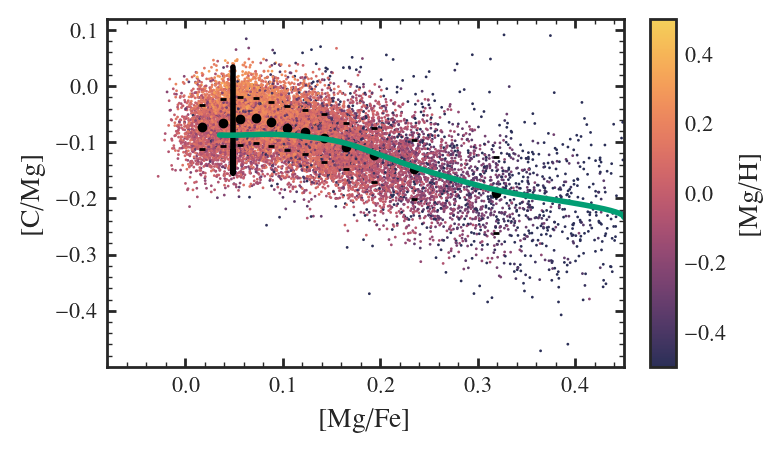

In [32]:
compare_caafe(model)

In [27]:
def compare_caafe_slice(model, c=-0.1, w=0.05, **kwargs):
    df = surp.plots.filter_metallicity(model, c=c, w=w)
    scatter_caafe(df)
    binned_caafe_slice(model, c0=c, w=w)
    plot_eq_caafe(**kwargs)
    sz_caafe(label="singlezone", lw=2, color="k")
    plot_ssp_femg(Z=gcem.MH_to_Z(c))

    plt.xlabel("[Mg/Fe]")
    plt.ylabel("[C/Mg]")

/astro/dboyea/.local/lib/python3.11/site-packages/vice/core/singlezone/singlezone.py:1797: VisibleRuntimeWarning: Functions of stellar mass and metallicity for asymptotic giant branch star yields may significantly increase the required integration time, especially for fine timestepping.
  return self.__c_version.run(output_times, capture = capture,
/astro/dboyea/.local/lib/python3.11/site-packages/vice/core/pickles.py:310: UserWarning: Encoding functions along with VICE outputs requires the package dill (installable via pip). The following attribute will not be saved with this output: c
  warnings.warn("""\
/astro/dboyea/.local/lib/python3.11/site-packages/vice/core/pickles.py:310: UserWarning: Encoding functions along with VICE outputs requires the package dill (installable via pip). The following attribute will not be saved with this output: n
  warnings.warn("""\
/astro/dboyea/.local/lib/python3.11/site-packages/vice/core/pickles.py:310: UserWarning: Encoding functions along with VI

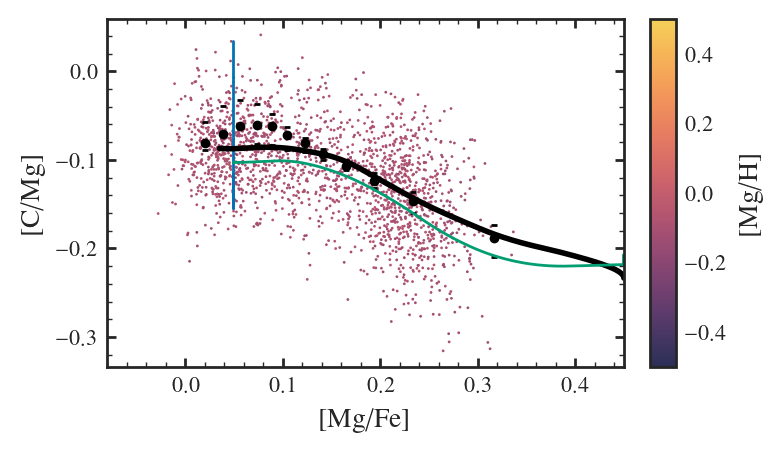

In [34]:
compare_caafe_slice(model)

In [50]:
def compare(model, sfh=None):
    fig, axs = plt.subplots(1, 2, figsize=(7, 10/3), sharey=True, gridspec_kw={"wspace": 0}, dpi=250)

    
    plt.sca(axs[0])
    compare_caah(model)
    plt.xlim(-0.5, 0.5)
    plt.ylim(-0.45, 0.15)
    
    
    plt.sca(axs[1])
    compare_caafe(model, sfh=sfh)
    plt.xlim(-0.08, 0.45)


In [73]:
def compare_gas(model, sfh=None):
    fig, axs = plt.subplots(1, 2, figsize=(7, 10/3), sharey=True, gridspec_kw={"wspace": 0}, dpi=250)

    
    plt.sca(axs[0])
    compare_cooh_gas(model)
    plt.xlim(-0.5, 0.5)
    plt.ylim(-0.45, 0.15)
    
    
    plt.sca(axs[1])
    compare_coofe_gas(model, sfh=sfh)
    plt.xlim(-0.08, 0.45)


/astro/dboyea/.local/lib/python3.11/site-packages/vice/core/singlezone/singlezone.py:1797: VisibleRuntimeWarning: Functions of stellar mass and metallicity for asymptotic giant branch star yields may significantly increase the required integration time, especially for fine timestepping.
  return self.__c_version.run(output_times, capture = capture,
/astro/dboyea/.local/lib/python3.11/site-packages/vice/core/pickles.py:310: UserWarning: Encoding functions along with VICE outputs requires the package dill (installable via pip). The following attribute will not be saved with this output: c
  warnings.warn("""\
/astro/dboyea/.local/lib/python3.11/site-packages/vice/core/pickles.py:310: UserWarning: Encoding functions along with VICE outputs requires the package dill (installable via pip). The following attribute will not be saved with this output: n
  warnings.warn("""\
/astro/dboyea/.local/lib/python3.11/site-packages/vice/core/pickles.py:310: UserWarning: Encoding functions along with VI

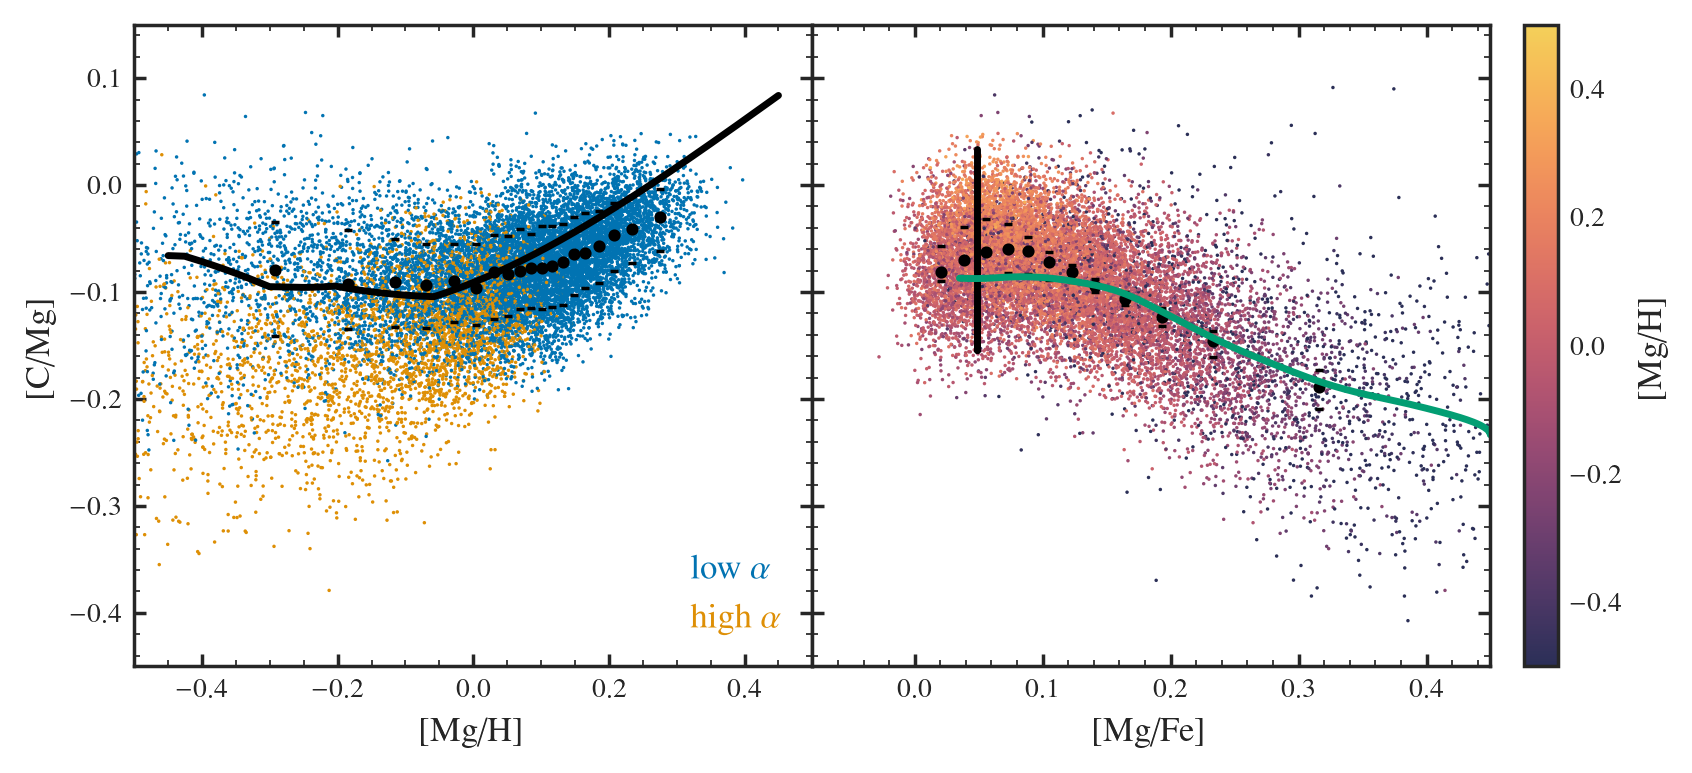

In [35]:
compare(model)

plt.savefig("figures/subgiants_equilibrium_reproduced.pdf")

# Actual comparisons

using  7.95


/astro/dboyea/.local/lib/python3.11/site-packages/vice/core/singlezone/singlezone.py:1797: VisibleRuntimeWarning: Functions of stellar mass and metallicity for asymptotic giant branch star yields may significantly increase the required integration time, especially for fine timestepping.
  return self.__c_version.run(output_times, capture = capture,
/astro/dboyea/.local/lib/python3.11/site-packages/vice/core/pickles.py:310: UserWarning: Encoding functions along with VICE outputs requires the package dill (installable via pip). The following attribute will not be saved with this output: c
  warnings.warn("""\
/astro/dboyea/.local/lib/python3.11/site-packages/vice/core/pickles.py:310: UserWarning: Encoding functions along with VICE outputs requires the package dill (installable via pip). The following attribute will not be saved with this output: n
  warnings.warn("""\
/astro/dboyea/.local/lib/python3.11/site-packages/vice/core/pickles.py:310: UserWarning: Encoding functions along with VI

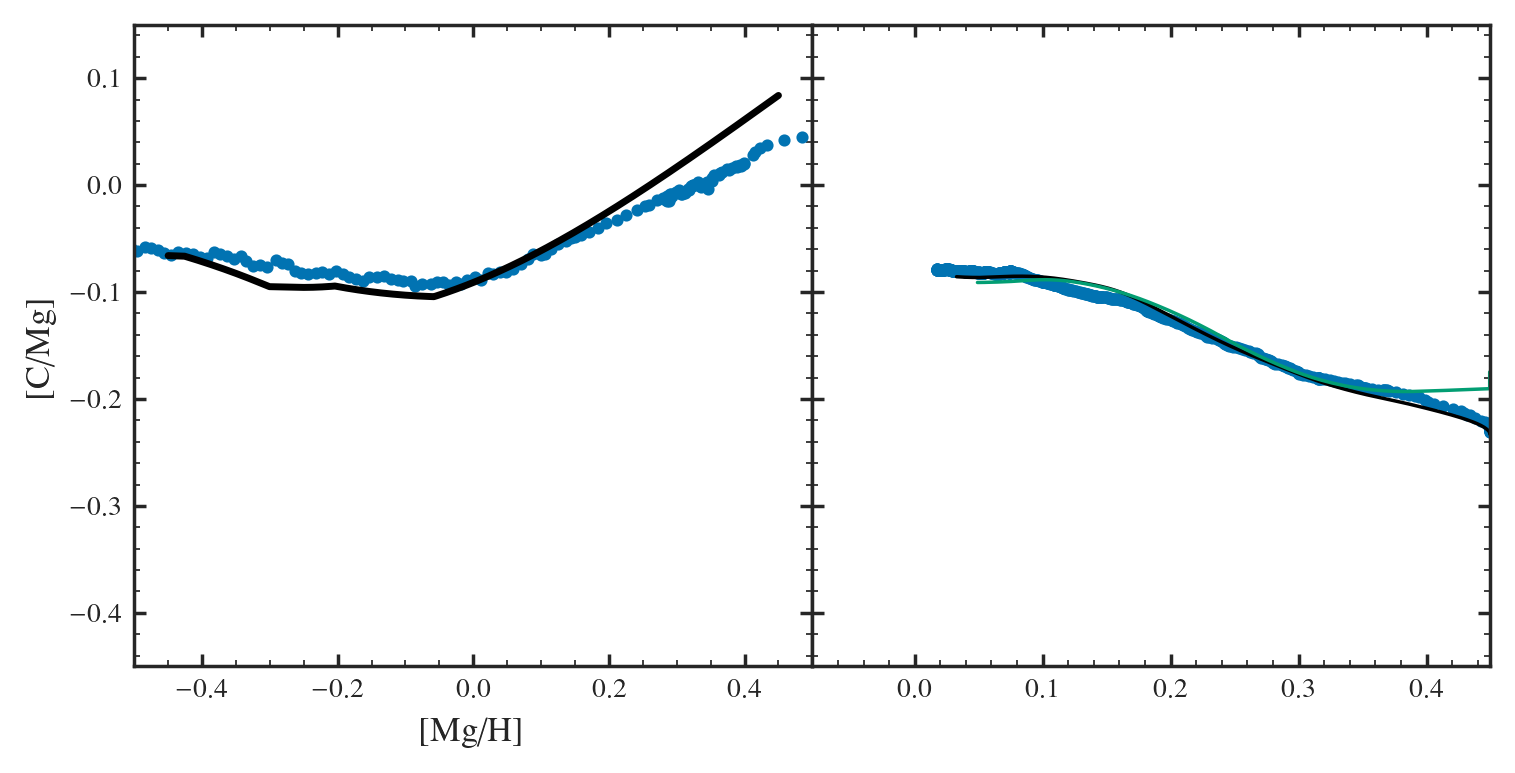

In [88]:
h = load_gas_model("fiducial/run")

compare_gas(h)

using  7.95


/astro/dboyea/.local/lib/python3.11/site-packages/vice/core/singlezone/singlezone.py:1797: VisibleRuntimeWarning: Functions of stellar mass and metallicity for asymptotic giant branch star yields may significantly increase the required integration time, especially for fine timestepping.
  return self.__c_version.run(output_times, capture = capture,
/astro/dboyea/.local/lib/python3.11/site-packages/vice/core/pickles.py:310: UserWarning: Encoding functions along with VICE outputs requires the package dill (installable via pip). The following attribute will not be saved with this output: c
  warnings.warn("""\
/astro/dboyea/.local/lib/python3.11/site-packages/vice/core/pickles.py:310: UserWarning: Encoding functions along with VICE outputs requires the package dill (installable via pip). The following attribute will not be saved with this output: n
  warnings.warn("""\
/astro/dboyea/.local/lib/python3.11/site-packages/vice/core/pickles.py:310: UserWarning: Encoding functions along with VI

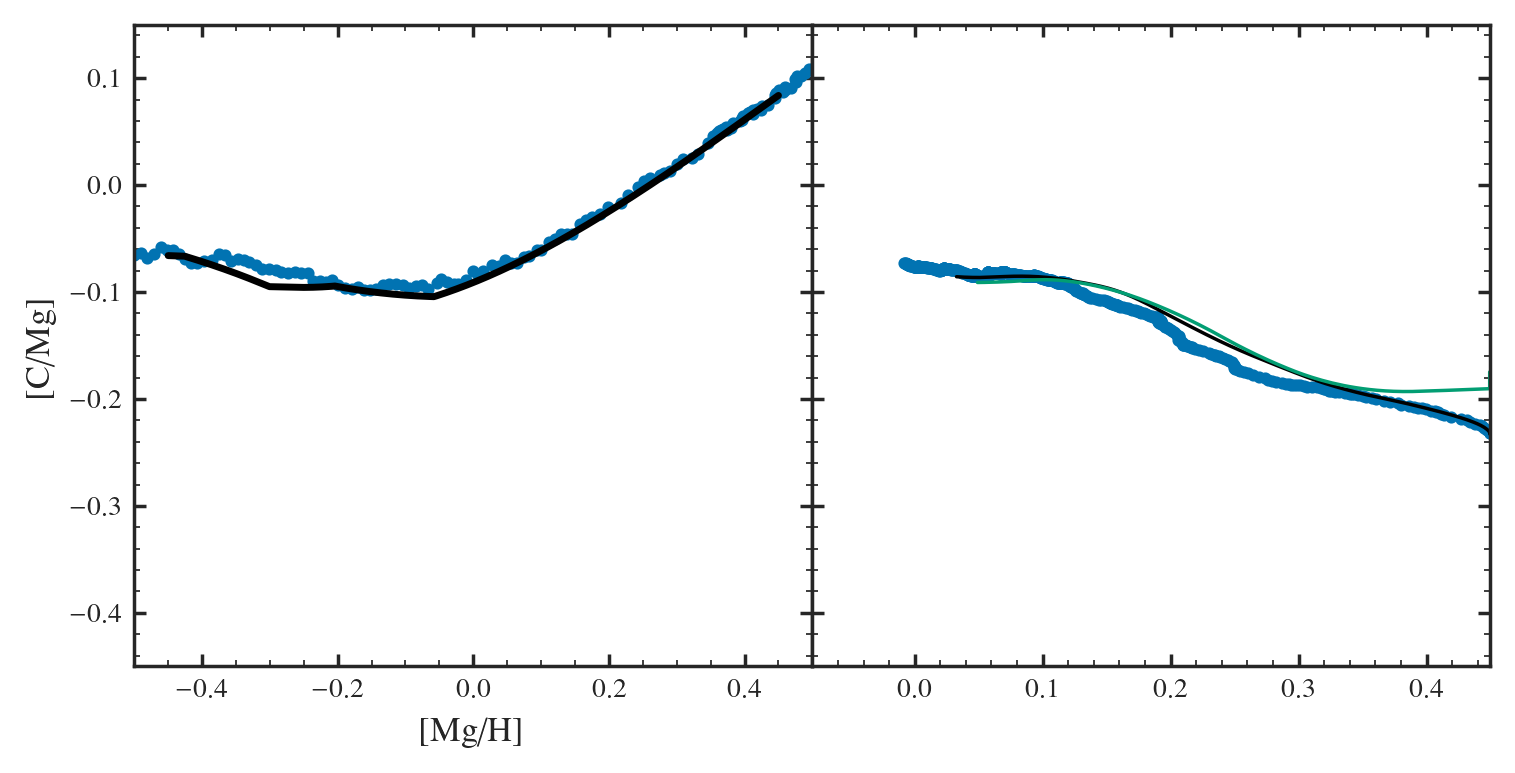

In [91]:
h = load_gas_model("fiducial/eta2")

compare_gas(h)

## twoinfall

In [74]:
params = surp.MWParams.from_file("../models/fiducial/twoinfall_liam/params.toml")

In [75]:
sfh = surp.simulation.star_formation_history.create_sfh_model(8, params)

t_T = 3.7
At/AT = 0.9878741182794751
r = 8
A21 = 3.655134237634058
tau2 = 4



/astro/dboyea/.local/lib/python3.11/site-packages/vice/core/singlezone/singlezone.py:1797: VisibleRuntimeWarning: Functions of stellar mass and metallicity for asymptotic giant branch star yields may significantly increase the required integration time, especially for fine timestepping.
  return self.__c_version.run(output_times, capture = capture,
/astro/dboyea/.local/lib/python3.11/site-packages/vice/core/pickles.py:310: UserWarning: Encoding functions along with VICE outputs requires the package dill (installable via pip). The following attribute will not be saved with this output: c
  warnings.warn("""\
/astro/dboyea/.local/lib/python3.11/site-packages/vice/core/pickles.py:310: UserWarning: Encoding functions along with VICE outputs requires the package dill (installable via pip). The following attribute will not be saved with this output: n
  warnings.warn("""\
/astro/dboyea/.local/lib/python3.11/site-packages/vice/core/pickles.py:310: UserWarning: Encoding functions along with VI

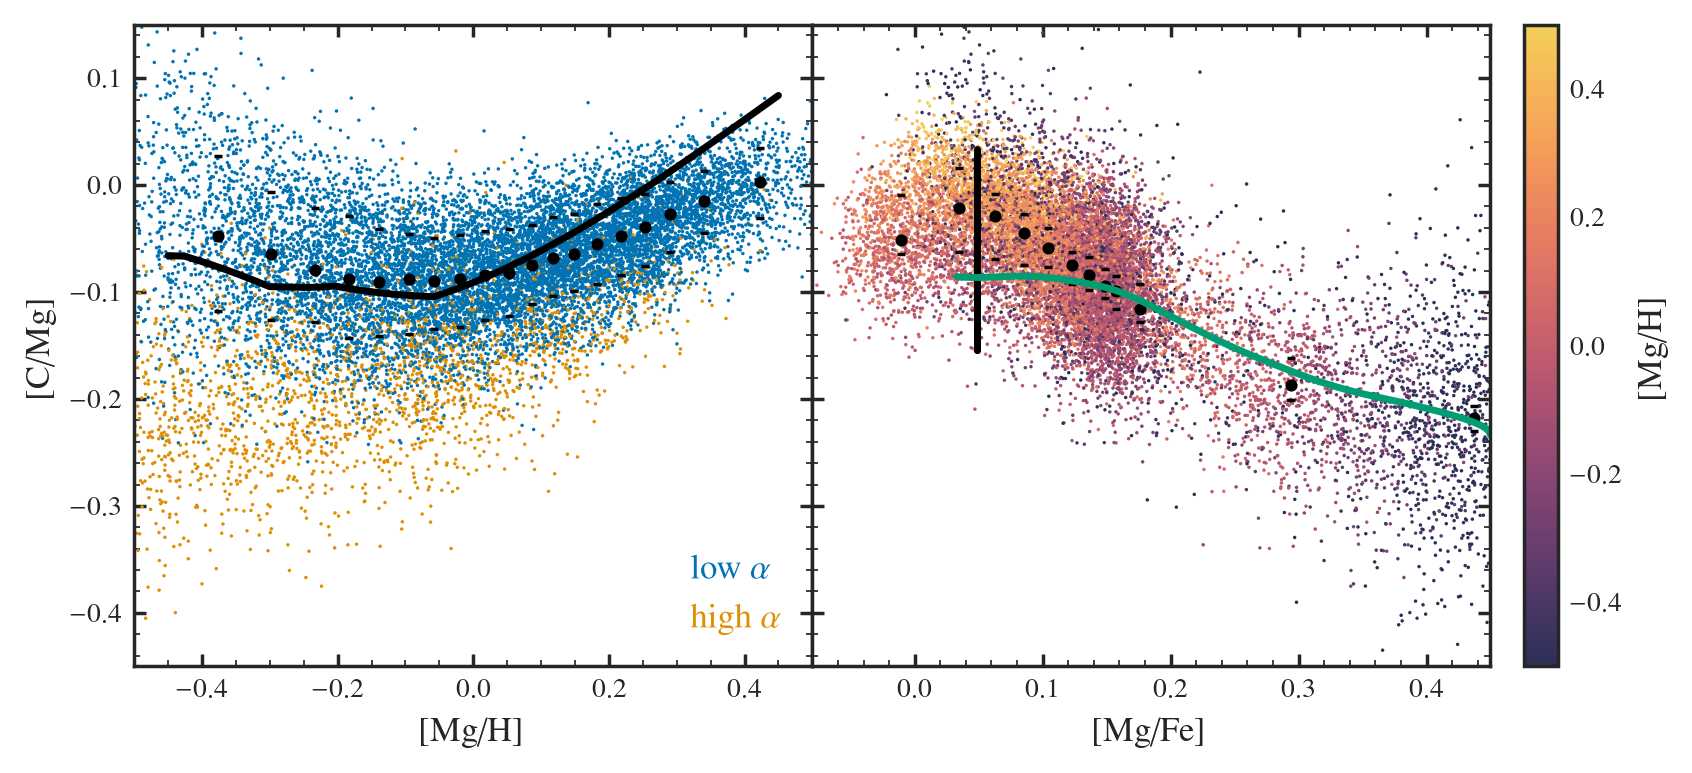

In [76]:
compare(model, sfh=sfh)

using  7.95


/astro/dboyea/.local/lib/python3.11/site-packages/vice/core/singlezone/singlezone.py:1797: VisibleRuntimeWarning: Functions of stellar mass and metallicity for asymptotic giant branch star yields may significantly increase the required integration time, especially for fine timestepping.
  return self.__c_version.run(output_times, capture = capture,
/astro/dboyea/.local/lib/python3.11/site-packages/vice/core/pickles.py:310: UserWarning: Encoding functions along with VICE outputs requires the package dill (installable via pip). The following attribute will not be saved with this output: c
  warnings.warn("""\
/astro/dboyea/.local/lib/python3.11/site-packages/vice/core/pickles.py:310: UserWarning: Encoding functions along with VICE outputs requires the package dill (installable via pip). The following attribute will not be saved with this output: n
  warnings.warn("""\
/astro/dboyea/.local/lib/python3.11/site-packages/vice/core/pickles.py:310: UserWarning: Encoding functions along with VI

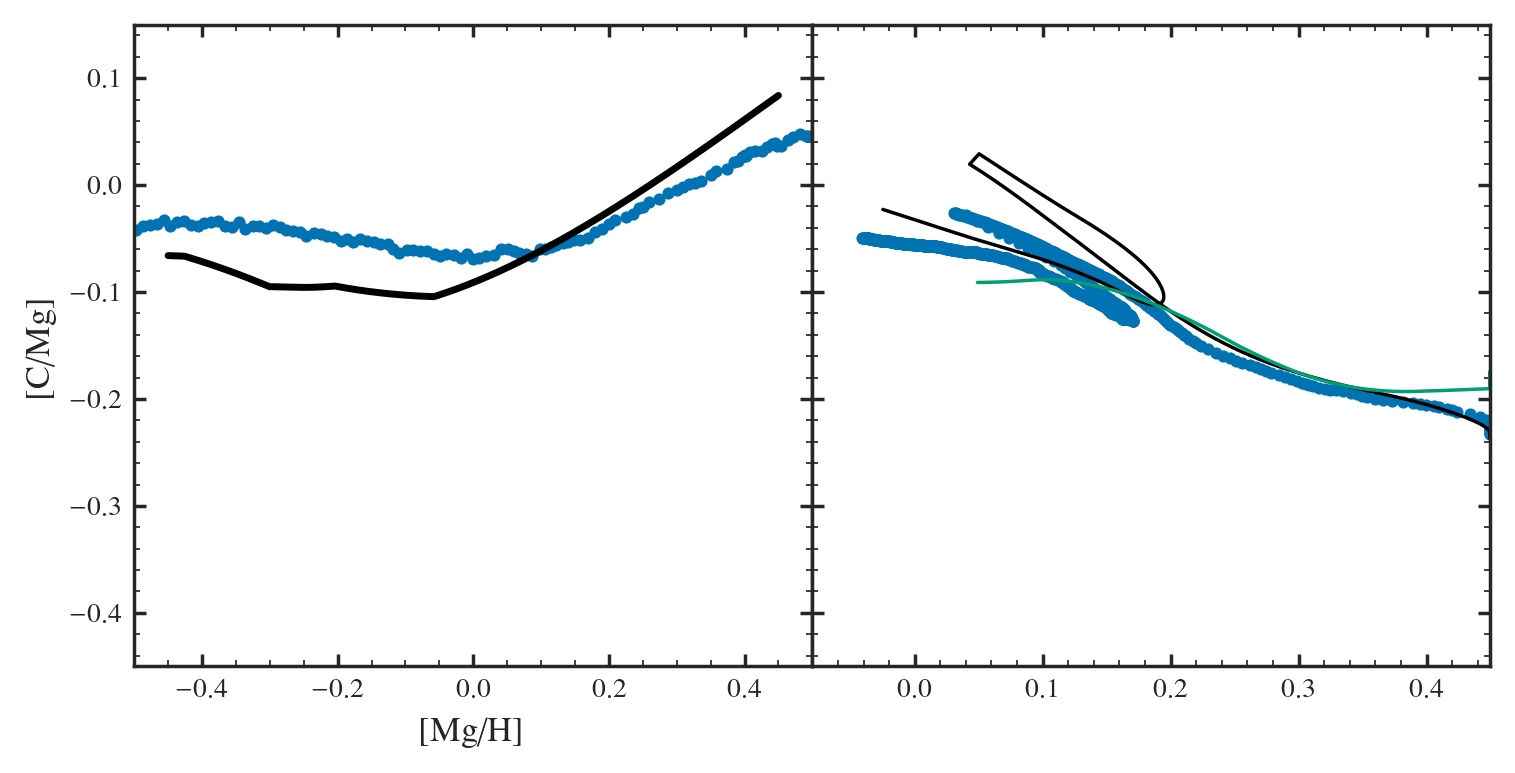

In [89]:
h = load_gas_model("fiducial/twoinfall_liam")

compare_gas(h, sfh=sfh)

In [8]:
df = surp.plots.filter_metallicity(model, c=-0.1, w=0.025)
plt.scatter(df.MG_FE, df.C_MG, s=0.3, alpha=0.3, label="model stars")
arya.medianplot(df, "MG_FE", "C_MG", binsize=100, color="k", label="median bins")
sz_caafe(color=arya.COLORS[2], lw=2, tau_star=2, tau_sfh=15, label="singlezone")
plt.xlabel("[Mg/Fe]")
plt.ylabel("[C/Mg]")
plt.title("fiducial metallicity filter")

plot_ssp_femg(gcem.MH_to_Z(-0.1), color=arya.COLORS[3], label="SSP (shifted by -0.05 dex in [Mg/Fe])", x_shift=-0.05)

plt.ylim(-0.4, 0)
arya.Legend(-1)

NameError: name 'model' is not defined

/users/PAS2232/aeyobd/VICE/vice/core/singlezone/singlezone.py:1797: VisibleRuntimeWarning: Functions of stellar mass and metallicity for asymptotic giant branch star yields may significantly increase the required integration time, especially for fine timestepping.
  return self.__c_version.run(output_times, capture = capture,
/users/PAS2232/aeyobd/VICE/vice/core/pickles.py:305: UserWarning: Could not pickle function. The following attribute will not be saved with this output: c
  warnings.warn("""\
/users/PAS2232/aeyobd/VICE/vice/core/pickles.py:305: UserWarning: Could not pickle function. The following attribute will not be saved with this output: o
  warnings.warn("""\
/users/PAS2232/aeyobd/VICE/vice/core/pickles.py:305: UserWarning: Could not pickle function. The following attribute will not be saved with this output: mg
  warnings.warn("""\
/users/PAS2232/aeyobd/VICE/vice/core/pickles.py:305: UserWarning: Could not pickle function. The following attribute will not be saved with thi

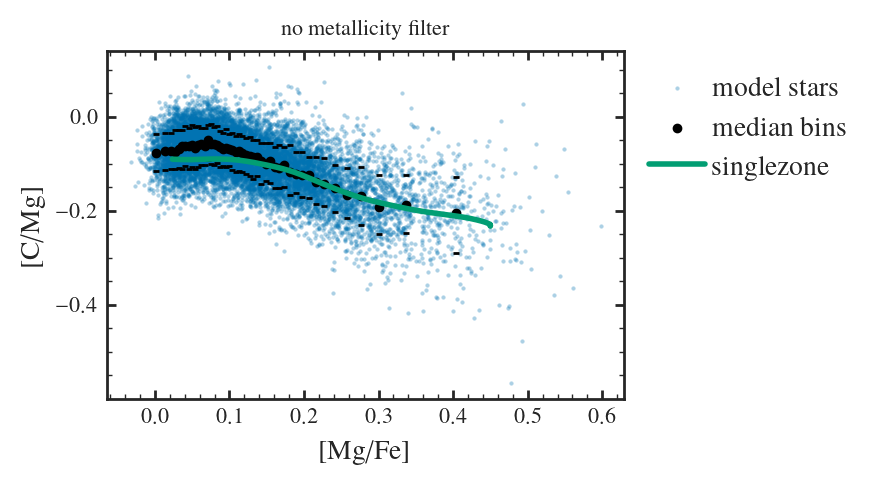

In [31]:
df = model
plt.scatter(df.MG_FE, df.C_MG, s=0.3, alpha=0.3, label="model stars")
arya.medianplot(df, "MG_FE", "C_MG", binsize=300, color="k", label="median bins")
sz_caafe(color=arya.COLORS[2], lw=2, tau_star=2, tau_sfh=15, label="singlezone")
plt.xlabel("[Mg/Fe]")
plt.ylabel("[C/Mg]")
plt.title("no metallicity filter")

arya.Legend(-1)

In [9]:
model = load_model("../models/C11_f0.2_Quadratic/")

NameError: name 'load_model' is not defined

In [10]:
for c in [-0.3, -0.1, 0.1, 0.2]:
    df = surp.plots.filter_metallicity(model, c=c, w=0.05)
    plt.scatter(df.MG_FE, df.C_MG, s=0.3, alpha=0.3, label="model stars")
    arya.medianplot(df, "MG_FE", "C_MG", binsize=200, color="k", label="median bins")
    sz_caafe(color=arya.COLORS[2], lw=2, tau_star=2, tau_sfh=15, label="singlezone")
    plt.xlabel("[Mg/Fe]")
    plt.ylabel("[C/Mg]")
    plt.title("fiducial metallicity filter")
    plot_ssp_femg(gcem.MH_to_Z(c), color=arya.COLORS[3], label="SSP (shifted by -0.05 dex in [Mg/Fe])", x_shift=-0.05)
    arya.Legend(-1)

    plt.ylim(-0.5, 0)
    plt.show()


NameError: name 'model' is not defined

/users/PAS2232/aeyobd/VICE/vice/core/singlezone/singlezone.py:1797: VisibleRuntimeWarning: Functions of stellar mass and metallicity for asymptotic giant branch star yields may significantly increase the required integration time, especially for fine timestepping.
  return self.__c_version.run(output_times, capture = capture,
/users/PAS2232/aeyobd/VICE/vice/core/pickles.py:305: UserWarning: Could not pickle function. The following attribute will not be saved with this output: c
  warnings.warn("""\
/users/PAS2232/aeyobd/VICE/vice/core/pickles.py:305: UserWarning: Could not pickle function. The following attribute will not be saved with this output: o
  warnings.warn("""\
/users/PAS2232/aeyobd/VICE/vice/core/pickles.py:305: UserWarning: Could not pickle function. The following attribute will not be saved with this output: mg
  warnings.warn("""\
/users/PAS2232/aeyobd/VICE/vice/core/pickles.py:305: UserWarning: Could not pickle function. The following attribute will not be saved with thi

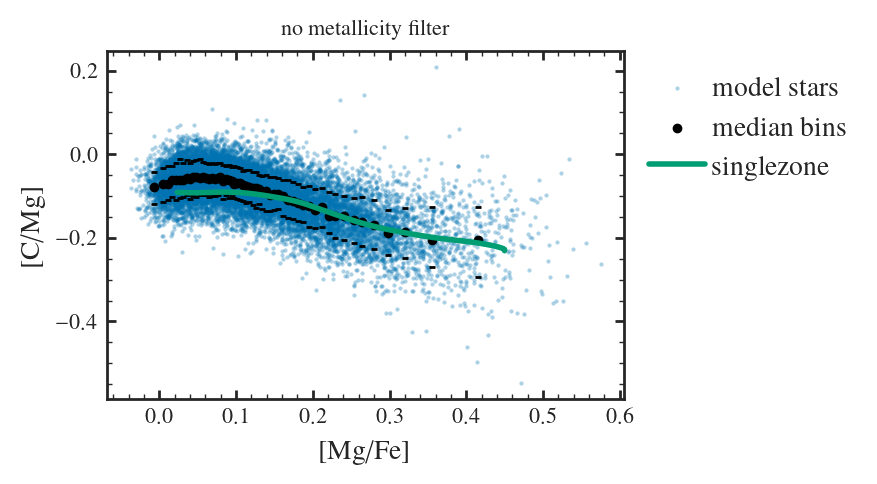

In [34]:
df = model
plt.scatter(df.MG_FE, df.C_MG, s=0.3, alpha=0.3, label="model stars")
arya.medianplot(df, "MG_FE", "C_MG", binsize=300, color="k", label="median bins")
sz_caafe(color=arya.COLORS[2], lw=2, tau_star=2, tau_sfh=15, label="singlezone")
plt.xlabel("[Mg/Fe]")
plt.ylabel("[C/Mg]")
plt.title("no metallicity filter")

arya.Legend(-1)

In [11]:
compare_caafe(model)

NameError: name 'compare_caafe' is not defined

In [12]:
compare("C11_piecelin")

NameError: name 'compare' is not defined

TypeError: Data source must be a DataFrame or Mapping, not <class 'str'>.

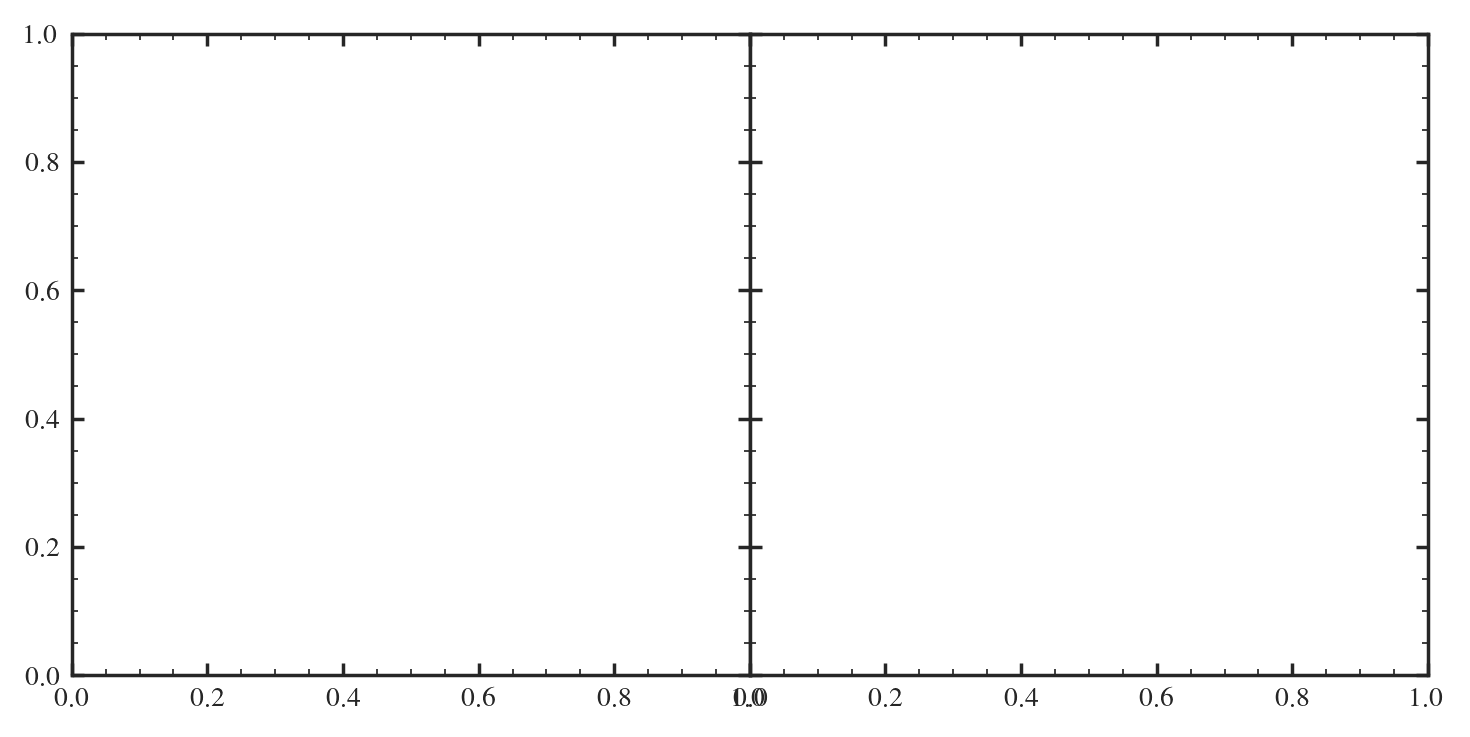

In [36]:
compare("C11_oob")

In [ ]:
compare("K16_oob")

/users/PAS2232/aeyobd/VICE/vice/core/singlezone/singlezone.py:1797: VisibleRuntimeWarning: Functions of stellar mass and metallicity for asymptotic giant branch star yields may significantly increase the required integration time, especially for fine timestepping.
  return self.__c_version.run(output_times, capture = capture,
/users/PAS2232/aeyobd/VICE/vice/core/pickles.py:305: UserWarning: Could not pickle function. The following attribute will not be saved with this output: c
  warnings.warn("""\
/users/PAS2232/aeyobd/VICE/vice/core/pickles.py:305: UserWarning: Could not pickle function. The following attribute will not be saved with this output: o
  warnings.warn("""\
/users/PAS2232/aeyobd/VICE/vice/core/pickles.py:305: UserWarning: Could not pickle function. The following attribute will not be saved with this output: mg
  warnings.warn("""\
/users/PAS2232/aeyobd/VICE/vice/core/pickles.py:305: UserWarning: Could not pickle function. The following attribute will not be saved with thi

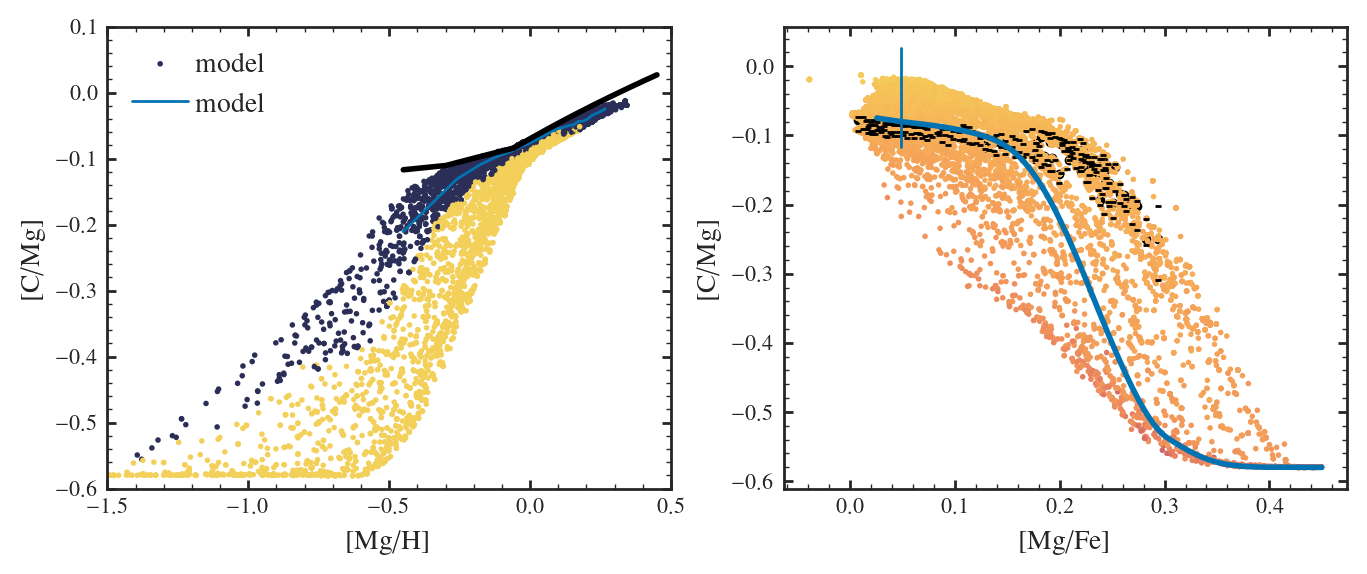

In [39]:
compare("V13_oob")

/users/PAS2232/aeyobd/VICE/vice/core/singlezone/singlezone.py:1797: VisibleRuntimeWarning: Functions of stellar mass and metallicity for asymptotic giant branch star yields may significantly increase the required integration time, especially for fine timestepping.
  return self.__c_version.run(output_times, capture = capture,
/users/PAS2232/aeyobd/VICE/vice/core/pickles.py:305: UserWarning: Could not pickle function. The following attribute will not be saved with this output: c
  warnings.warn("""\
/users/PAS2232/aeyobd/VICE/vice/core/pickles.py:305: UserWarning: Could not pickle function. The following attribute will not be saved with this output: o
  warnings.warn("""\
/users/PAS2232/aeyobd/VICE/vice/core/pickles.py:305: UserWarning: Could not pickle function. The following attribute will not be saved with this output: mg
  warnings.warn("""\
/users/PAS2232/aeyobd/VICE/vice/core/pickles.py:305: UserWarning: Could not pickle function. The following attribute will not be saved with thi

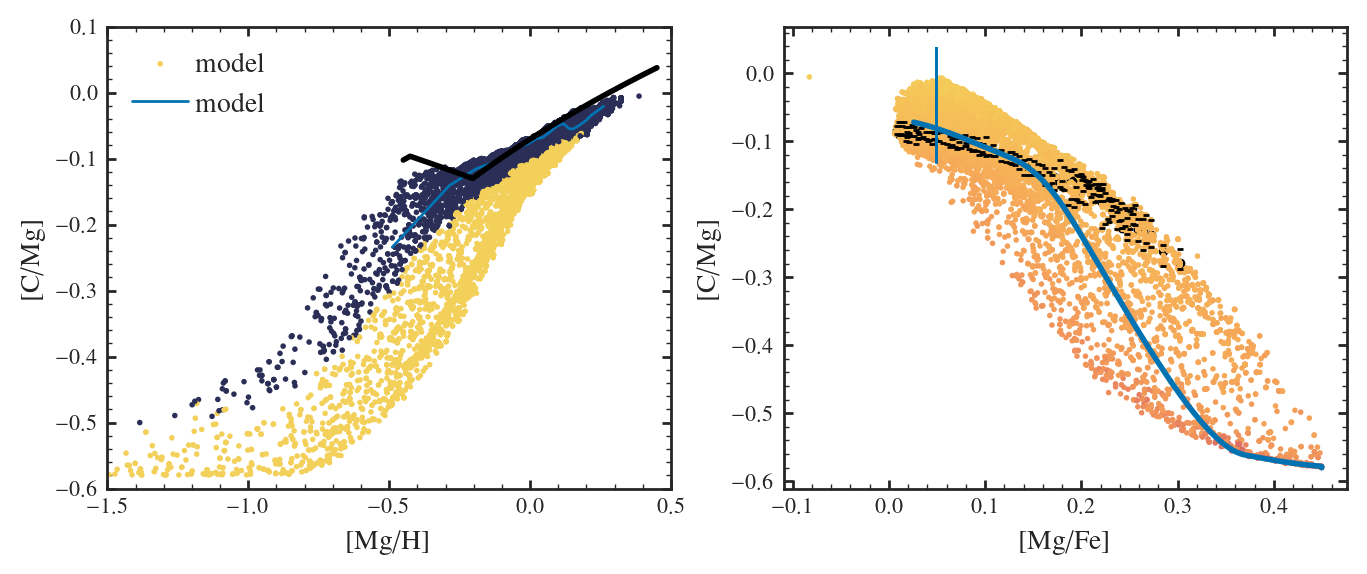

In [40]:
compare("P16_oob")

/users/PAS2232/aeyobd/VICE/vice/core/singlezone/singlezone.py:1797: VisibleRuntimeWarning: Functions of stellar mass and metallicity for asymptotic giant branch star yields may significantly increase the required integration time, especially for fine timestepping.
  return self.__c_version.run(output_times, capture = capture,
/users/PAS2232/aeyobd/VICE/vice/core/pickles.py:305: UserWarning: Could not pickle function. The following attribute will not be saved with this output: c
  warnings.warn("""\
/users/PAS2232/aeyobd/VICE/vice/core/pickles.py:305: UserWarning: Could not pickle function. The following attribute will not be saved with this output: o
  warnings.warn("""\
/users/PAS2232/aeyobd/VICE/vice/core/pickles.py:305: UserWarning: Could not pickle function. The following attribute will not be saved with this output: mg
  warnings.warn("""\
/users/PAS2232/aeyobd/VICE/vice/core/pickles.py:305: UserWarning: Could not pickle function. The following attribute will not be saved with thi

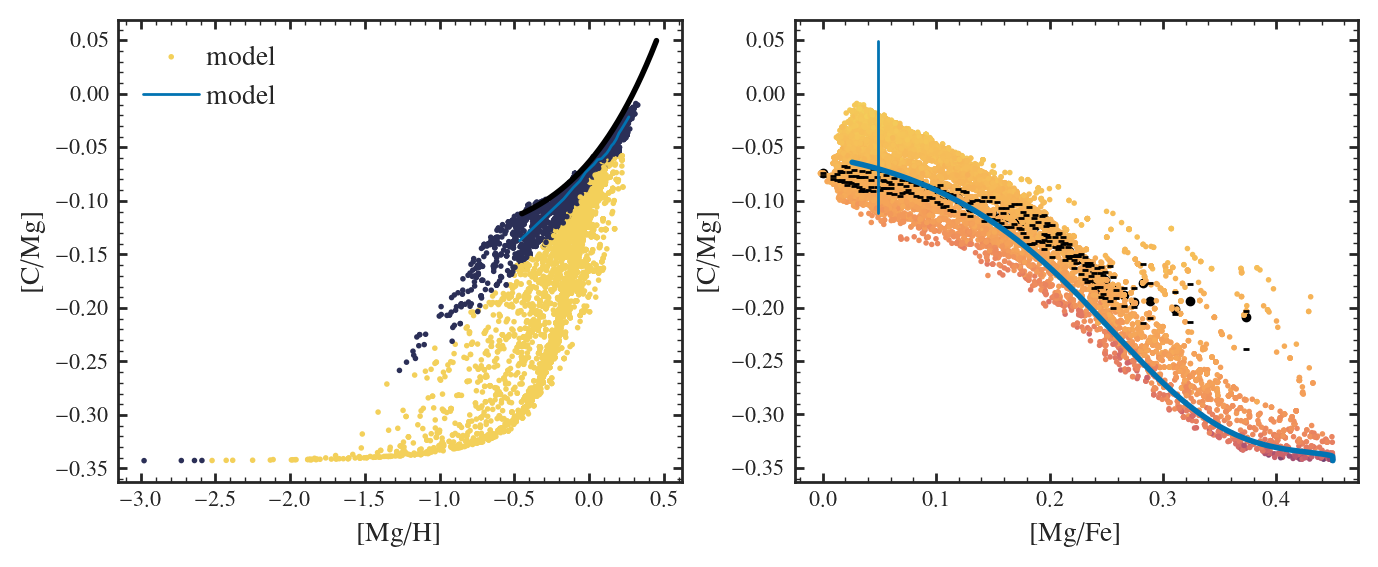

In [87]:
compare("A_f0.2_zeta_agb-0.02_t_d0.3_tau_agb0.3")

In [41]:
fiducial = surp.ViceModel.from_saved("../models/C11_f0.2/model.json")

Text(0.5, 1.0, 'Binned APOGEE trends')

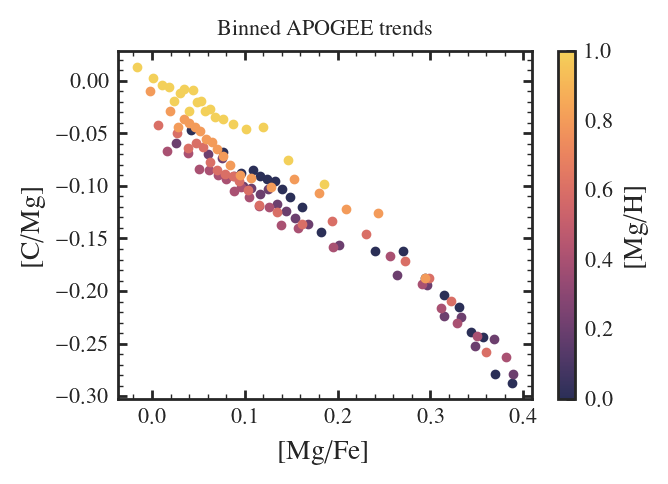

In [42]:
hm = arya.figure.colorbar.HueMap((-0.3, 0.3))

for c in np.linspace(-0.3, 0.3, 6):
    df = surp.plots.filter_metallicity(surp.subgiants,w=0.05,c=c)
    arya.medianplot(df, "MG_FE", "C_MG", numbins=20, color=hm(c), errorbar=None)

plt.colorbar(label="[Mg/H]")
plt.xlabel("[Mg/Fe]")
plt.ylabel("[C/Mg]")
plt.title("Binned APOGEE trends")

# Gas phase equilibrium

In [21]:
def plot_gas_eq(name):
    model = surp.ViceModel.from_file(f"../models/{name}/model.json")
    surp.set_yields(surp.YieldParams.from_file(f"../models/{name}/yield_params.json"))
    
    h = model.history
    h = h[h.time == np.max(h.time)]
    
    plt.plot(h.R, h["C_MG"], label="present day ISM")
    x = h.O_H
    y = calc_eq_caah(x)
    plt.plot(h.R, y, label="equilibrium")
    
    plt.xlim(2, 14)
    plt.ylim(-0.3, 0.1)
    plt.xlabel("Radius / kpc")
    plt.ylabel("[C/Mg]")

    arya.Legend(-1)

yields set to Magg et al. 2022 abundances
Yield settings
X        Z_solar    CC                             agb                            SN Ia                          

c        3.39e-03   2.30e-03 + 1.63e-03 [M/H] or   1.44 × cristallo11             0                              
                    8.67e-04, else                                                                               

n        1.04e-03   5.00e-04                       5.02e-04 M Z/Z0                0                              

o        7.33e-03   7.13e-03                       0                              0                              

mg       6.71e-04   6.52e-04                       0                              0                              

fe       1.37e-03   4.73e-04                       0                              7.70e-04                       





/users/PAS2232/aeyobd/surp/surp/gce_math.py:125: RuntimeWarning: invalid value encountered in log10
  return np.log10(data) - np.log10(vice.solar_z(ele) / vice.solar_z(ele2))


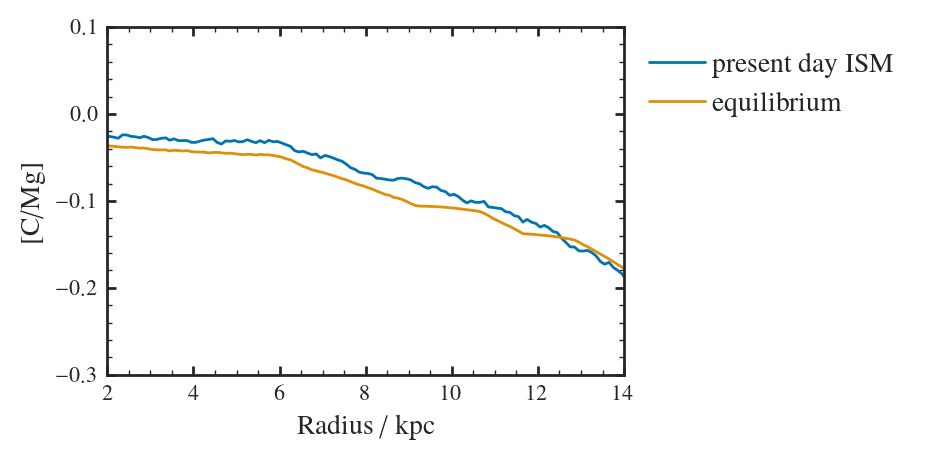

In [22]:
plot_gas_eq("C11_f0.2")

yields set to Magg et al. 2022 abundances
Yield settings
X        Z_solar    CC                             agb                            SN Ia                          

c        3.39e-03   4.00e-03 MH^2 + 2.00e-03 MH +  1.44 × cristallo11             0                              
                    2.20e-03                                                                                     

n        1.04e-03   5.00e-04                       5.02e-04 M Z/Z0                0                              

o        7.33e-03   7.13e-03                       0                              0                              

mg       6.71e-04   6.52e-04                       0                              0                              

fe       1.37e-03   4.73e-04                       0                              7.70e-04                       





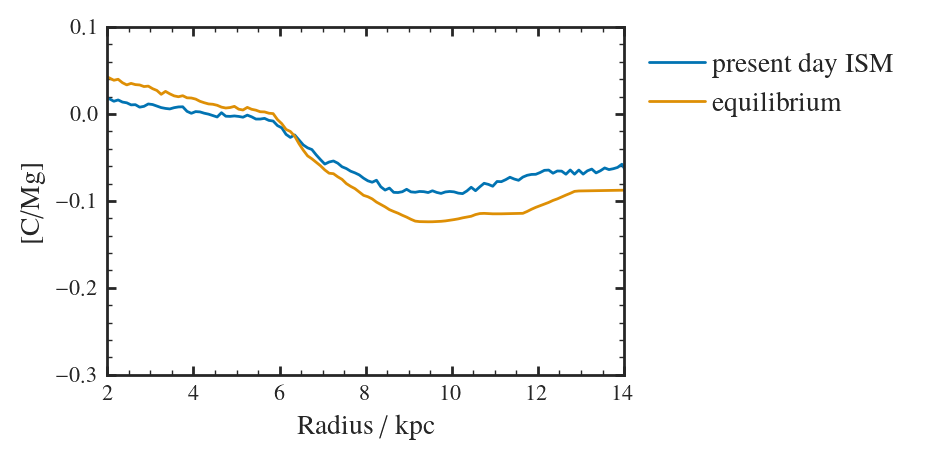

In [26]:
plot_gas_eq("C11_f0.2_Quadratic")

yields set to Magg et al. 2022 abundances
Yield settings
X        Z_solar    CC                             agb                            SN Ia                          

c        3.39e-03   2.88e-03 + 1.12e-03 [M/H] or   0.00 × cristallo11             0                              
                    8.67e-04, else                                                                               

n        1.04e-03   5.00e-04                       5.02e-04 M Z/Z0                0                              

o        7.33e-03   7.13e-03                       0                              0                              

mg       6.71e-04   6.52e-04                       0                              0                              

fe       1.37e-03   4.73e-04                       0                              7.70e-04                       





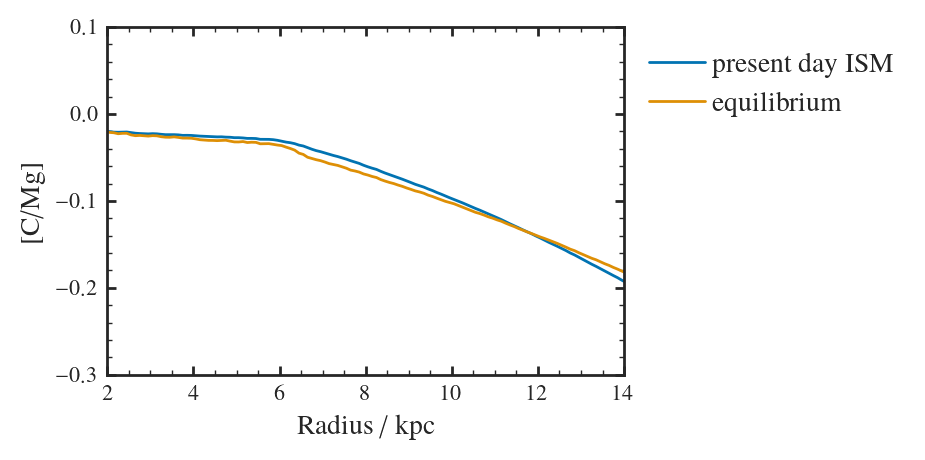

In [30]:
plot_gas_eq("C11_f0.0")

# SSP

In [74]:
def compare_ssp_caafe(name):
    model = load_model(name)

    MH=-0.1
    df = surp.plots.filter_metallicity(model, c=MH)
    plt.scatter(df.MG_FE_true, df.C_MG_true, s=0.1, alpha=1, vmin=-0.5)
    for dMH in [ -0.15, -0.1, -0.05, 0, 0.05]:
        plot_ssp_femg(Z=gcem.MH_to_Z(MH - dMH), color=arya.COLORS[1], lw=1)

    plt.xlabel("[Mg/Fe]")
    plt.ylabel("[C/Mg]")

/tmp/slurmtmp.27851406/ipykernel_95946/2307334858.py:6: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin' will be ignored
  plt.scatter(df.MG_FE_true, df.C_MG_true, s=0.1, alpha=1, vmin=-0.5)
/tmp/slurmtmp.27851406/ipykernel_95946/1533341937.py:6: RuntimeWarning: invalid value encountered in divide
  c_mg = gcem.abund_to_brak(np.array(m_c)/m_mg, "C", "MG")
/tmp/slurmtmp.27851406/ipykernel_95946/1533341937.py:7: RuntimeWarning: invalid value encountered in divide
  mg_fe = gcem.abund_to_brak(np.array(m_mg)/m_fe, "MG", "FE")


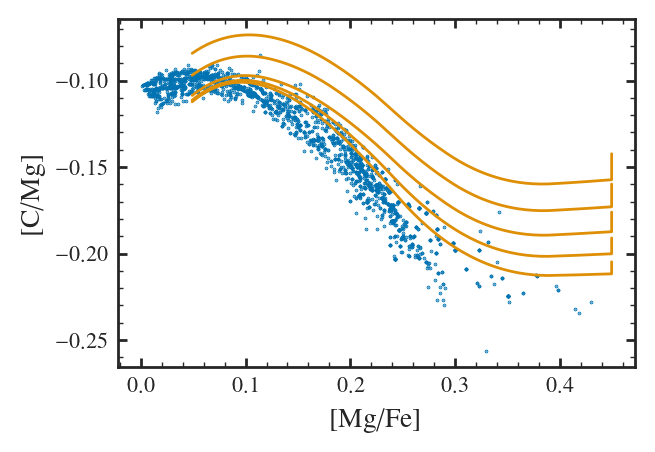

In [75]:
compare_ssp_caafe("C11_f0.2")

/tmp/slurmtmp.27851406/ipykernel_95946/2307334858.py:6: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin' will be ignored
  plt.scatter(df.MG_FE_true, df.C_MG_true, s=0.1, alpha=1, vmin=-0.5)
/tmp/slurmtmp.27851406/ipykernel_95946/1533341937.py:6: RuntimeWarning: invalid value encountered in divide
  c_mg = gcem.abund_to_brak(np.array(m_c)/m_mg, "C", "MG")
/tmp/slurmtmp.27851406/ipykernel_95946/1533341937.py:7: RuntimeWarning: invalid value encountered in divide
  mg_fe = gcem.abund_to_brak(np.array(m_mg)/m_fe, "MG", "FE")


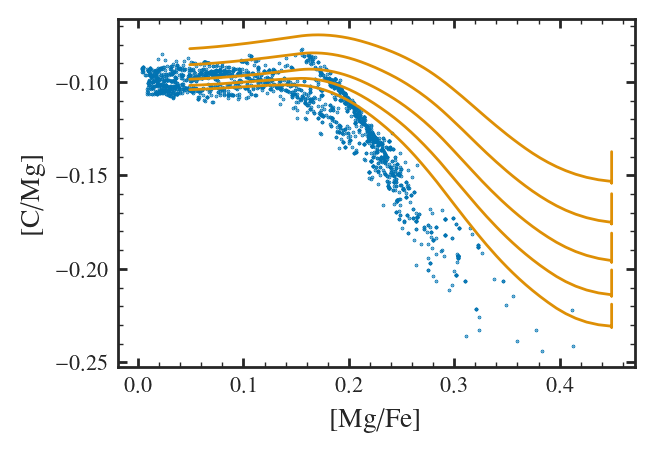

In [76]:
compare_ssp_caafe("K16_f0.2")

/tmp/slurmtmp.27851406/ipykernel_95946/2307334858.py:6: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin' will be ignored
  plt.scatter(df.MG_FE_true, df.C_MG_true, s=0.1, alpha=1, vmin=-0.5)
/tmp/slurmtmp.27851406/ipykernel_95946/1533341937.py:6: RuntimeWarning: invalid value encountered in divide
  c_mg = gcem.abund_to_brak(np.array(m_c)/m_mg, "C", "MG")
/tmp/slurmtmp.27851406/ipykernel_95946/1533341937.py:7: RuntimeWarning: invalid value encountered in divide
  mg_fe = gcem.abund_to_brak(np.array(m_mg)/m_fe, "MG", "FE")


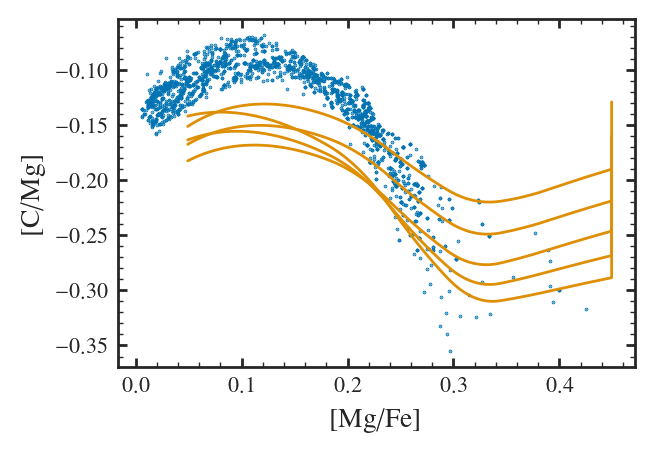

In [77]:
compare_ssp_caafe("V13_f0.2")

/tmp/slurmtmp.27851406/ipykernel_95946/2307334858.py:6: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin' will be ignored
  plt.scatter(df.MG_FE_true, df.C_MG_true, s=0.1, alpha=1, vmin=-0.5)
/tmp/slurmtmp.27851406/ipykernel_95946/1533341937.py:6: RuntimeWarning: invalid value encountered in divide
  c_mg = gcem.abund_to_brak(np.array(m_c)/m_mg, "C", "MG")
/tmp/slurmtmp.27851406/ipykernel_95946/1533341937.py:7: RuntimeWarning: invalid value encountered in divide
  mg_fe = gcem.abund_to_brak(np.array(m_mg)/m_fe, "MG", "FE")


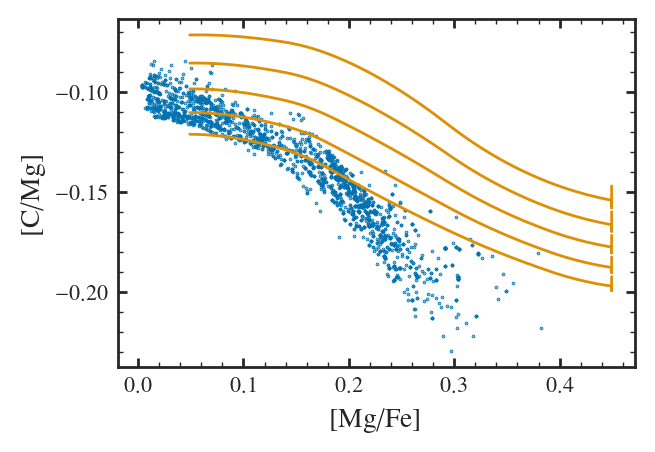

In [78]:
compare_ssp_caafe("P16_f0.2")

/tmp/slurmtmp.27851406/ipykernel_95946/2307334858.py:6: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin' will be ignored
  plt.scatter(df.MG_FE_true, df.C_MG_true, s=0.1, alpha=1, vmin=-0.5)
/tmp/slurmtmp.27851406/ipykernel_95946/1533341937.py:6: RuntimeWarning: invalid value encountered in divide
  c_mg = gcem.abund_to_brak(np.array(m_c)/m_mg, "C", "MG")
/tmp/slurmtmp.27851406/ipykernel_95946/1533341937.py:7: RuntimeWarning: invalid value encountered in divide
  mg_fe = gcem.abund_to_brak(np.array(m_mg)/m_fe, "MG", "FE")


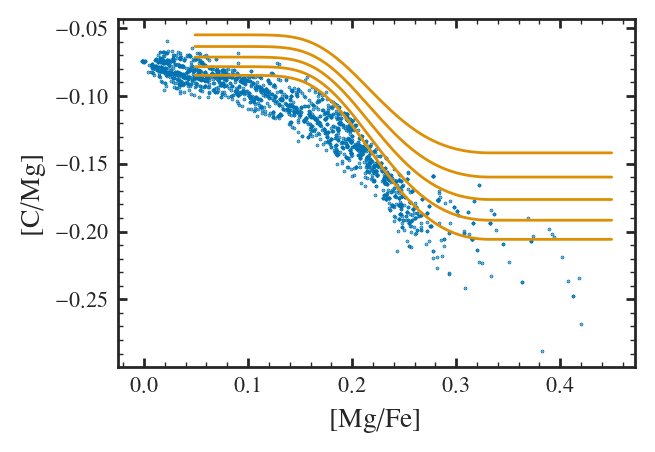

In [80]:
compare_ssp_caafe("A_f0.2_zeta_agb-0.02_t_d0.3_tau_agb0.3")

/tmp/slurmtmp.27851406/ipykernel_95946/2307334858.py:6: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin' will be ignored
  plt.scatter(df.MG_FE_true, df.C_MG_true, s=0.1, alpha=1, vmin=-0.5)
/tmp/slurmtmp.27851406/ipykernel_95946/1533341937.py:6: RuntimeWarning: invalid value encountered in divide
  c_mg = gcem.abund_to_brak(np.array(m_c)/m_mg, "C", "MG")
/tmp/slurmtmp.27851406/ipykernel_95946/1533341937.py:7: RuntimeWarning: invalid value encountered in divide
  mg_fe = gcem.abund_to_brak(np.array(m_mg)/m_fe, "MG", "FE")


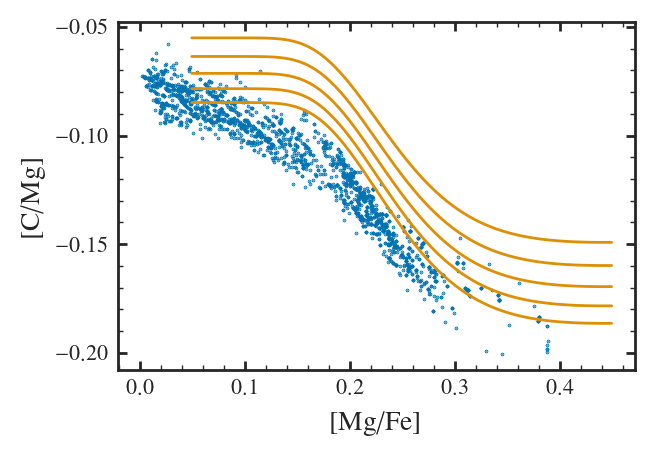

In [86]:
compare_ssp_caafe("A_f0.2_zeta_agb0.0_t_d0.15_tau_agb0.3")

# Singlezone

In [7]:
import astropy.units as u

In [10]:
sz, h = run_singlezone(dt=0.003)

/users/PAS2232/aeyobd/VICE/vice/core/singlezone/singlezone.py:1797: VisibleRuntimeWarning: Functions of stellar mass and metallicity for asymptotic giant branch star yields may significantly increase the required integration time, especially for fine timestepping.
  return self.__c_version.run(output_times, capture = capture,
/users/PAS2232/aeyobd/VICE/vice/core/pickles.py:305: UserWarning: Could not pickle function. The following attribute will not be saved with this output: c
  warnings.warn("""\
/users/PAS2232/aeyobd/VICE/vice/core/pickles.py:305: UserWarning: Could not pickle function. The following attribute will not be saved with this output: o
  warnings.warn("""\
/users/PAS2232/aeyobd/VICE/vice/core/pickles.py:305: UserWarning: Could not pickle function. The following attribute will not be saved with this output: mg
  warnings.warn("""\
/users/PAS2232/aeyobd/VICE/vice/core/pickles.py:305: UserWarning: Could not pickle function. The following attribute will not be saved with thi

In [11]:
ele = "c"

y_c = vice.yields.ccsne.settings[ele]
if isinstance(y_c, float):
    y_cc = lambda x: y_c
else:
    y_cc = y_c
Mc = h[f"mass({ele})"].values * u.Msun
time = h.time.values * u.Gyr
time = time.to("yr")

r =h["r_eff"]
eta = h["eta_0"]
r = 0.4
denom =  (1 + eta - r).values
sfr = h.sfr.values * u.Msun / u.year
Zc = h[f"z({ele})"].values

dM_dep = -sfr * Zc * denom 
y_cc_t = [y_cc(z) for z in h["z"]]
dM_cc = sfr * y_cc_t
dM_c = np.gradient(Mc, time)


dM_agb = dM_c - dM_cc - dM_dep

f_agb = dM_agb / (dM_agb + dM_cc)


/users/PAS2232/aeyobd/.local/lib/python3.10/site-packages/astropy/units/quantity.py:666: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/users/PAS2232/aeyobd/.local/lib/python3.10/site-packages/astropy/units/quantity.py:666: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


In [12]:
dt = np.gradient(time)
M_agb = np.sum(dM_agb * dt)
M_cc = np.sum(dM_cc * dt)

In [13]:
f_tot = M_agb / (M_agb + M_cc)

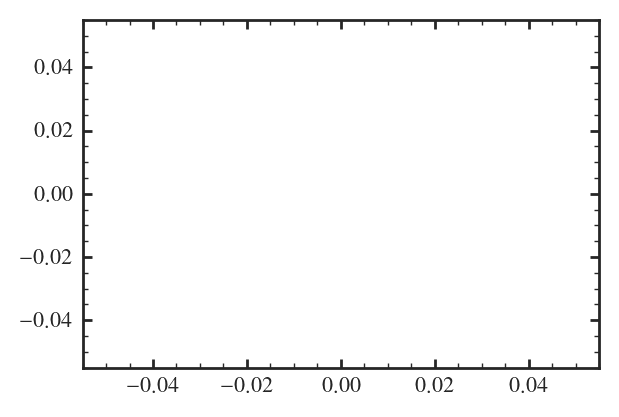

In [14]:
plt.plot(Mc, (np.cumsum(dM_c * np.gradient(time)) - Mc) / Mc)

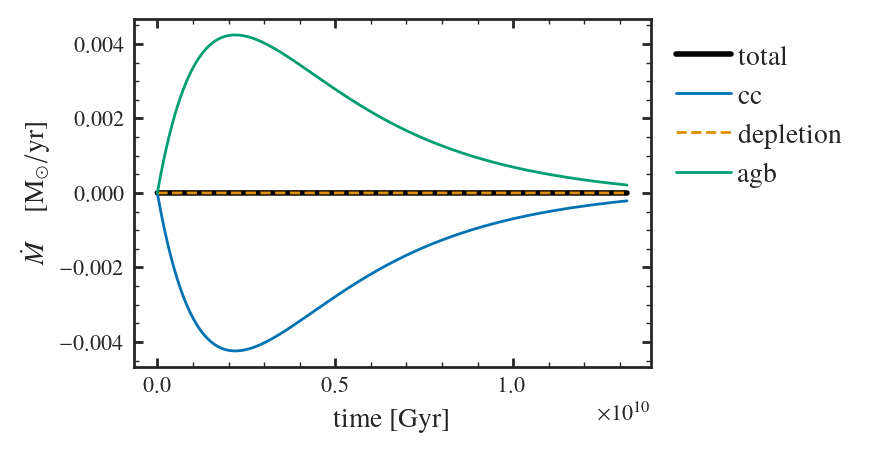

In [15]:
plt.plot(time, dM_c, "k-", lw=2, label="total")
plt.plot(time, dM_cc, label="cc")
plt.plot(time, dM_dep, "--", label="depletion")
plt.plot(time, dM_agb, label="agb")
plt.xlabel("time [Gyr]")
plt.ylabel(r"$\dot{M}\quad [\rm M_\odot / yr]$")
arya.Legend(-1)

0.20344861831806338


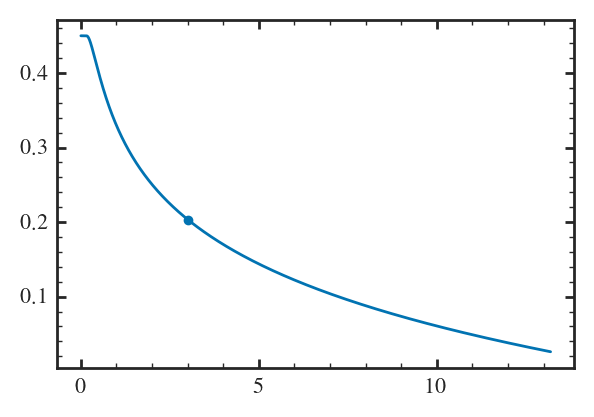

In [16]:
tau_late = 3*u.Gyr
a_fe = -h["[fe/o]"]
plt.plot(time/1e9, a_fe)
idx = np.where(time > tau_late)[0][0]

fe_half = a_fe[idx]
plt.scatter(time[idx]/1e9, fe_half)
print(fe_half)

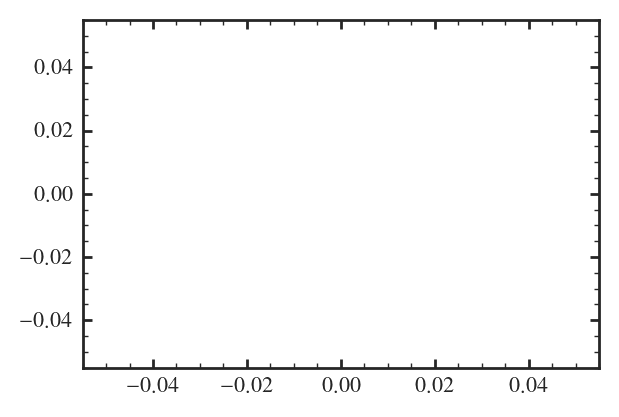

In [17]:
plt.plot(time, f_agb)
plt.axhline(f_tot)

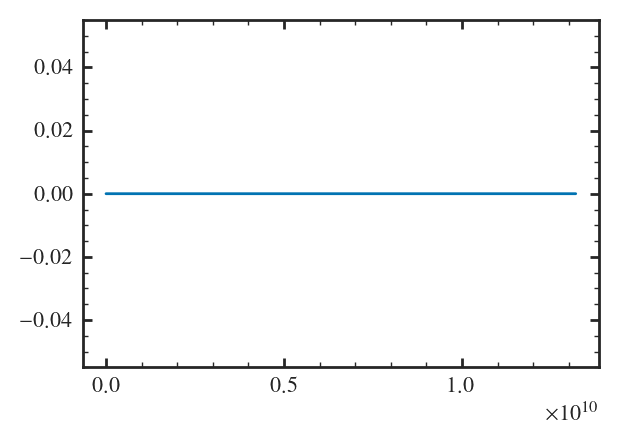

In [18]:
plt.plot(time, Mc)

In [19]:
h = fiducial.history
m_star = h["sfr"]*1e9 # Msun/yr (default)
denom = 1 + h["eta_0"] - h["r_eff"]
Mc = h["mass(c)"] # Msun

Zc = Mc / h["mgas"]
dt = h.time.unique()[1] # Gyr

smooth = 10
Mc_dot = np.concatenate([np.zeros(smooth), 
                         Mc[smooth:] - np.array(Mc[:-smooth]),
                        ]
                       )/(smooth*dt)
Z = h["z"]

y_cc = vice.yields.ccsne.settings["c"]
yc_cc = y_cc(Z)
y_c = (Mc_dot + denom*Zc*m_star)/m_star
y_c_agb = y_c - yc_cc
f_agb = np.array(y_c_agb/y_c)

X = np.reshape(f_agb, (200, -1))

NameError: name 'fiducial' is not defined